In [1]:
#@title setup colab env
from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive')
%cd drive/MyDrive/commonlitreadabilityprize/baseline/

!pip install transformers
clear_output()

In [2]:
#@title setup XLA
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
clear_output()

In [3]:
import sys
sys.path.append('../input/learner')

from learner.all import *

In [4]:
import os
assert os.environ['COLAB_TPU_ADDR']
 
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

# For half precision training in TPUs
os.environ["XLA_USE_BF16"] = '1'
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = '10000000'

In [5]:
#@title lib { vertical-output: true }
# lib
import copy
import os
import gc
import random
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from functools import partial
from typing import Callable, List, Union

from fastprogress import master_bar, progress_bar
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers


import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('models'):
    os.mkdir('models')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.9.0+cu102'

In [6]:
data_path = '../input/commonlitreadabilityprize/'

trn_df = pd.read_csv(data_path + 'train.csv')
#trn_df.drop(trn_df.query('target == 0').index, inplace=True)
#trn_df.reset_index(inplace=True)
test_df = pd.read_csv(data_path + 'test.csv')
sub_df = pd.read_csv(data_path + 'sample_submission.csv')

# config

In [7]:
class CFG:
    debug: bool = False
        
    seed = SEED

    # device
    #device = xm.xla_device()
    #device:torch.device = torch.device('cpu')
    #device: torch.device = torch.device('cuda:0')
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data set
    bs: int = 128
    num_workers: int = 0

    # model
    model_name = 'roberta-base'
    store_name = 'roberta-base'
    epochs: int = 10

    # gradient
    iters_to_accumulate: int = 1
    max_grad_norm: float = 1.
    loss_func = None
    metric_funcs: List[Union[Callable, None]] = [rmse, mae]

    # optimizer
    lr: int = 2e-5
    lrs: float = [lr, lr*2, lr*5, lr*10]  # 4 groups
    wd: float = 1e-2
        
    # tokenizer
    max_len = 256

    # distributional trainin
    nprocs = 8  # 1 or 8


cfg = CFG()
cfg.loss_func = nn.MSELoss()
seed_everything(cfg.seed)


if cfg.debug:
    trn_df = trn_df.sample(frac=0.30).reset_index()
    warnings.filterwarnings('always')
    pass

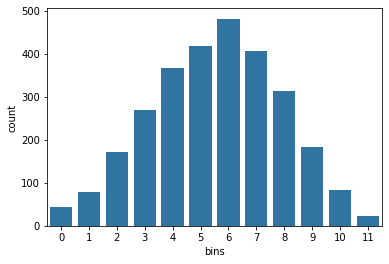

In [8]:
bins = round(1 + np.log2(len(trn_df)))
trn_df['bins'] = pd.cut(trn_df.target, bins, labels=False)

sns.countplot(trn_df['bins'], color='C0')


skf = KFold(5, shuffle=True, random_state=cfg.seed)
for fold, (trn_idx, val_idx) in enumerate(skf.split(trn_df, y=trn_df.bins), 1):
    trn_df.loc[val_idx, 'fold'] = fold
trn_df.loc[trn_df.target == 0, 'fold'] = -1

# dataset

In [9]:
class BERTDataSet(Dataset):
    def __init__(self, df, tokenizer):
        df = df.reset_index()
        self.encodeds = tokenizer.batch_encode_plus(
            df.excerpt.tolist(),
            add_special_tokens=True,  # <s> and </s>
            max_length=cfg.max_len,          # default 512 for bert
            padding='max_length',    # padding  <pad>
            truncation=True,         # cut if length > max length
           
        )
        self.targets = df.target.values[:, None]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):

        ids = torch.tensor(self.encodeds['input_ids'][idx], dtype=torch.long)
        mask = torch.tensor(self.encodeds['attention_mask'][idx], dtype=torch.long)

        target = torch.tensor(self.targets[idx], dtype=torch.float)

        return [ids, mask], target
    
    
if cfg.debug:
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
    trn_ds = BERTDataSet(trn_df, tokenizer)
    trn_dl = DataLoader(trn_ds,
                        batch_size=cfg.bs,
                        shuffle=True,
                        num_workers=cfg.num_workers,
                        pin_memory=True)
    print(len(trn_ds))
    for x in trn_dl:
        print(x)
        break

# model

In [10]:
class AttentionHead(nn.Module):
    def __init__(self, in_size=768, h_size=512, o_size=1):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_size, h_size), 
            nn.Tanh(),  
            nn.Linear(h_size, o_size), 
            nn.Softmax(dim=1)
        )
        #self.linear = nn.Linear(in_size, o_size)
        
    def forward(self, features):
        out = self.attention(features) * features
        # (bs, lens, 768) to (bs, 768)
        out = torch.sum(out, dim=1)
        #out = self.linear(out)
        return out
    
    
class CLPRModel(nn.Module):
    def __init__(self, model_name):
        super(CLPRModel, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.config.layer_norm_eps = 1e-7
        self.config.hidden_dropout_prob = 0.5
        self.transformer = AutoModel.from_pretrained(model_name, self.config)
        
        self.hidden_size = self.config.hidden_size
        self.attention = AttentionHead(in_size=self.hidden_size)
        self.head = nn.Linear(self.hidden_size, 1)
        
    #def forward(self, input_id, attention_mask):
    def forward(self, x):
        #out = self.transformer(input_id, attention_mask)['last_hidden_state']
        out = self.transformer(*x)['last_hidden_state']
        out = self.attention(out)
        out = self.head(out)
        return out
 
    
if cfg.debug:
    model = CLPRModel(cfg.model_name)
    preds = model(x[0])
    print(preds.shape)

# optimizer

In [11]:
def create_optimizer(model, cfg):
    named_parameters = list(model.named_parameters())

    backbone_parameters = named_parameters[:199]
    head_parameters = named_parameters[199:]

    head_group = [params for (name, params) in head_parameters]

    parameters = []
    parameters.append({"params": head_group,
                       "weight_decay": 0.,
                       "lr": cfg.lrs[3]})

    for layer_num, (name, params) in enumerate(backbone_parameters):
        weight_decay = 0.0 if 'LayerNorm' in name or 'bias' in name else cfg.wd

        lr = cfg.lrs[0]

        if layer_num >= 69:
            lr = cfg.lrs[1]

        if layer_num >= 133:
            lr = cfg.lrs[2]

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters)


def get_scheduler(optimizer, cfg):
    num_training_steps = cfg.trn_dl_lens * cfg.epochs
    num_warmup_steps = int(cfg.trn_dl_lens * 0.1)
    return transformers.get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps,
        num_training_steps
    )

cfg.create_optimizer = create_optimizer

if 0:
    # create dataloader
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
    trn_ds = BERTDataSet(trn_df, tokenizer)
    trn_dl = DataLoader(trn_ds,
                        batch_size=cfg.bs,
                        shuffle=True,
                        num_workers=cfg.num_workers,
                        pin_memory=True)
    # create model
    model = CLPRModel('roberta-base')
    
    # create scheduler
    optimizer = create_optimizer(model, cfg)
    scheduler = get_scheduler(optimizer, cfg)
    
    # get lr
    lrs = []
    for epoch in range(cfg.epochs):
        for _ in trn_dl:
            lrs.append(scheduler.get_last_lr())
            optimizer.step()
            scheduler.step()
    lrs = sorted(set([*zip(*lrs)]))
    
    # plot
    plt.figure(figsize=(12, 3))
    for i, lr in enumerate(lrs, 1):
        plt.subplot(1, 4, i)
        plt.title(f'group{i}')
        plt.plot(lr)
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.tight_layout()
    plt.show()

# Learner

In [12]:
def create_dl(ds, cfg, mode='train'):  #######TPU######
    shuffle = True if mode == 'train' else False
    drop_last = shuffle      

    sampler = torch.utils.data.distributed.DistributedSampler(
            ds,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=shuffle
            )
    loader = torch.utils.data.DataLoader(
      ds,
      batch_size=cfg.bs,
      sampler=sampler,
      num_workers=cfg.num_workers,
      drop_last=drop_last)
    
    return loader

In [13]:
class MeshReduceValue(Callback):
    def __init__(self, reduce_fn=np.mean):
        self.reduce_fn = partial(xm.mesh_reduce, reduce_fn=reduce_fn)
    def after_epoch(self):
        if not self.train:
            self.learner.trn_loss = self.reduce_fn('trn_loss', self.trn_loss)
            self.learner.val_loss = self.reduce_fn('val_loss', self.val_loss)

            for idx, (trn_metric, val_metric, metric_func) in enumerate(zip(self.trn_metrics,
                                                self.val_metrics, 
                                                self.metric_funcs)):
                self.learner.trn_metrics[idx] = self.reduce_fn(f'trn_{metric_func.__name__}', trn_metric)
                self.learner.val_metrics[idx] = self.reduce_fn(f'val_{metric_func.__name__}', val_metric)                

In [14]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
model = CLPRModel(cfg.model_name)

In [15]:
def train_func(rank):
    fold = 1
    global cfg
    global tokenizer
    #global trn_ds, val_ds
    _cfg = copy.deepcopy(cfg)
    _cfg.bs = _cfg.bs // xm.xrt_world_size()
    #_cfg.lr = _cfg.lr * xm.xrt_world_size()
    #_cfg.lrs = [lr * xm.xrt_world_size() for lr in _cfg.lrs]
    
    if rank == 0:
        logger_name = datetime.today().strftime("%Y-%m-%d_%H_%M_%S")
        logger_name = 'log/' + logger_name
        logger = get_logger(logger_name, verbose=False)


    device = xm.xla_device()
    _cfg.device = device
    trn_ds = BERTDataSet(trn_df.query(f'fold != {fold}'), tokenizer)
    trn_dl = create_dl(trn_ds, _cfg, 'train')

    val_ds = BERTDataSet(trn_df.query(f'fold == {fold}'), tokenizer)
    val_dl = create_dl(val_ds, _cfg, 'valid')
    _cfg.trn_dl_lens = len(trn_dl)

    dls = DataLoaders(trn_dl, val_dl)


    _cfg.backbone_config = model.config

    if rank == 0:  # main process
        cbs = [
                MeshReduceValue(),
                Scheduler(get_scheduler),
                ProgressBar(), 
                Logger(logger),
                ModelCheckPoint(
                    store_name=_cfg.store_name,
                    auto_load=False,
                    skip_start=0, 
                    verbose=1
                    ),
        ]
    else:
        cbs = [
                MeshReduceValue(), 
                Scheduler(get_scheduler),
                ModelCheckPoint(
                    store_name=_cfg.store_name,
                    auto_load=False,
                    skip_start=0, 
                    verbose=0,
                    ),
        ]
    learner = Learner_MultiTPU(_cfg, model, dls, cbs)

    # training
    learner.fit_single()

    if rank == 0: #######TPU######
        plot_history(learner)
        plot_lr(learner)


def _mp_fn(rank):
    train_func(rank)

INFO:learner.callbacks:

INFO:learner.callbacks:** Setup **

INFO:learner.callbacks:Time: 2021-08-02 19:43:41.830255

INFO:learner.callbacks:Parameters:
INFO:learner.callbacks:	backbone_config:RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.5,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

INFO:learner.callbacks:	bs:16
INFO:learner.callbacks:	create_optimizer:<function create_optimizer at 0x7f47cd18a200>
INFO:learner.callbacks:	debug:Fal

epoch,train loss,val loss,train rmse,val rmse,train mae,val mae,time
1,1.017837,0.558472,0.983398,0.735059,0.806396,0.591797,0:42
2,0.442519,0.375269,0.650979,0.603076,0.527990,0.495020,0:16
3,0.297033,0.331958,0.535975,0.566064,0.430334,0.467090,0:17
4,0.257339,0.329919,0.499110,0.564746,0.402071,0.469824,0:16
5,0.239258,0.447998,0.481000,0.659619,0.384823,0.557178,0:16
6,0.217045,0.391724,0.458166,0.616357,0.368437,0.516895,0:15
7,0.216689,0.348474,0.457620,0.580859,0.368423,0.484668,0:15
8,0.216456,0.408154,0.457864,0.629395,0.367223,0.529688,0:15
9,0.210657,0.400269,0.451100,0.623096,0.361558,0.523975,0:15
10,0.210255,0.400073,0.450684,0.623145,0.362082,0.524023,0:15


INFO:learner.callbacks:|    0:42|  1.9614e-04|        1|        17|  1.017837|  0.558472|    0.983398|    0.735059|    0.806396|    0.591797|
INFO:learner.callbacks:|    0:16|  1.8282e-04|        2|        34|  0.442519|  0.375269|    0.650979|    0.603076|    0.527990|    0.495020|
INFO:learner.callbacks:|    0:17|  1.6131e-04|        3|        51|  0.297033|  0.331958|    0.535975|    0.566064|    0.430334|    0.467090|
INFO:learner.callbacks:|    0:16|  1.3372e-04|        4|        68|  0.257339|  0.329919|    0.499110|    0.564746|    0.402071|    0.469824|
INFO:learner.callbacks:|    0:16|  1.0279e-04|        5|        85|  0.239258|  0.447998|    0.481000|    0.659619|    0.384823|    0.557178|
INFO:learner.callbacks:|    0:15|  7.1584e-05|        6|       102|  0.217045|  0.391724|    0.458166|    0.616357|    0.368437|    0.516895|
INFO:learner.callbacks:|    0:15|  4.3194e-05|        7|       119|  0.216689|  0.348474|    0.457620|    0.580859|    0.368423|    0.484668|
INFO:l

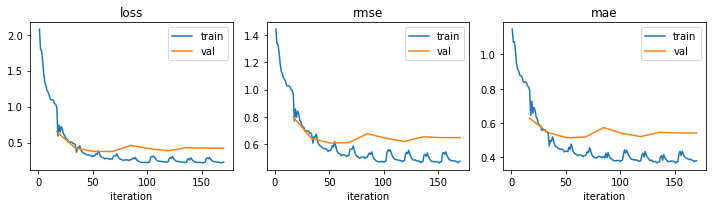

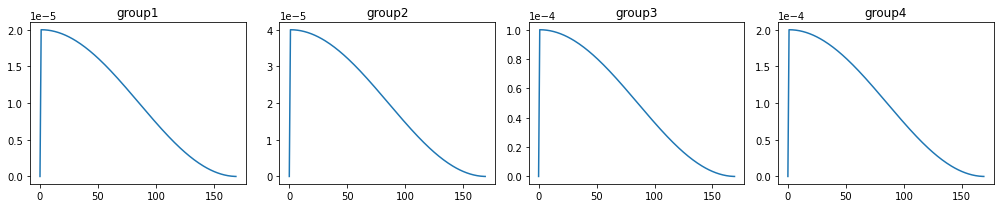

In [16]:
xmp.spawn(_mp_fn, args=(), nprocs=cfg.nprocs, start_method='fork')

In [24]:
# note: The server uses Coordinated Universal Time.
with open('./log/2021-08-02_19_43_32.log') as f:
    file = f.read()
print(file)



** Setup **

Time: 2021-08-02 19:43:41.830255

Parameters:
	backbone_config:RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.5,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

	bs:16
	create_optimizer:<function create_optimizer at 0x7f47cd18a200>
	debug:False
	device:xla:1
	epochs:10
	iters_to_accumulate:1
	loss_func:MSELoss()
	lr:2e-05
	lrs:[2e-05, 4e-05, 0.0001, 0.0002]
	max_grad_norm:1.0
	max_len:256
	metric_funcs:[<function rmse at 0